## POSE TEST
Learning pose in a self-supervised fashion requires a moving camera in time (and possibly not moving objects...)
Unfortunately, in real world scenarios static camera sequences may occur.
In the following tests we aim to study the behaviour of well-known methods in literature


In [10]:
from __future__ import division
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from monodepth2.flow_utils import read_pose, read_flo_file, flow_to_image, get_EPE

%matplotlib inline
cur_dir=os.getcwd()

# MONODEPTH2

## SEQUENCE 1

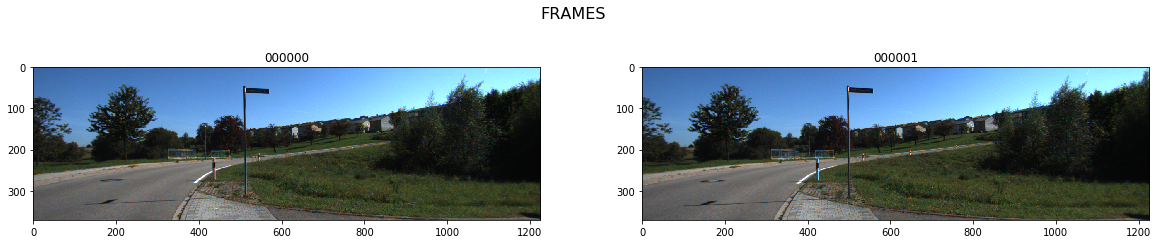

In [11]:
t0_img = cv2.imread(os.path.join(cur_dir,'images','000000.png'))
t1_img = cv2.imread(os.path.join(cur_dir,'images','000001.png'))
t0_img = cv2.cvtColor(t0_img, cv2.COLOR_BGR2RGB)
t1_img = cv2.cvtColor(t1_img, cv2.COLOR_BGR2RGB)

counter = 0
fig = plt.figure(figsize=(20,7))
fig.suptitle("FRAMES", fontsize=16)
for img,title in zip([t0_img, t1_img],['000000','000001']):
    ax = plt.subplot(221+counter)
    ax.title.set_text(title)
    plt.imshow(img)
    counter += 1

plt.show()

### Real 
In this test, we want to display the `Rigid Flow` on a real sequence, so frames T0 and T1 belong to the KITTI sequence.
We use [Monodepth2](https://arxiv.org/pdf/1806.01260.pdf) to get the pose and the disparity

**NOTE**: Intrinsics of KITTI are known

**NOTE**: Disparity is known less to a scale factor. We turn it into depth using the formula (1./(disp+1e-7)), then we apply the same scale factor used in the original paper to limit depth predictions in the range (1m,100m)

POSE: 
 T:[ 0.00074865 -0.02130056  0.00258728] 
 R:[-5.0012942e-04  4.1464009e-05 -4.5723515e-03]


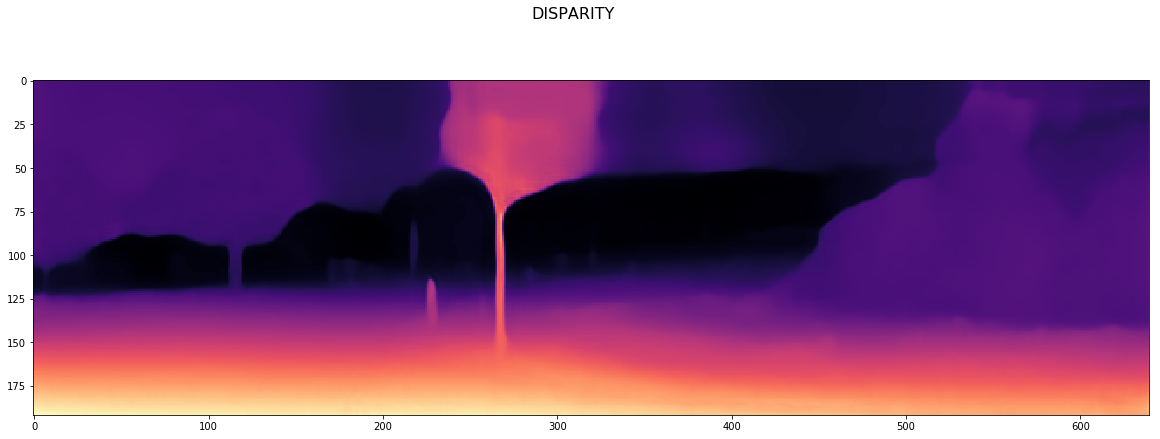

In [12]:
disp = np.load(os.path.join(cur_dir,'monodepth2','disp_0.npy'))
fig = plt.figure(figsize=(20,7))
fig.suptitle("DISPARITY", fontsize=16)
plt.imshow(disp, cmap='magma')

real_pose  = read_pose(os.path.join(cur_dir,'monodepth2','real_poses.txt'))
pose = real_pose[1]
print('POSE: \n T:{} \n R:{}'.format(pose[:3], pose[3:]))

The resulting rigid flow is the following

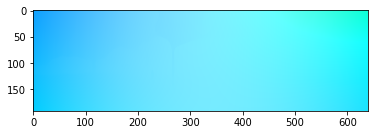

In [13]:
rigid_flow = read_flo_file(os.path.join(cur_dir,'outputs','rigid_flow_real_0.flo'))
rigid_flow = flow_to_image(rigid_flow)
plt.imshow(rigid_flow)


## Fake Sequence
Now, we want to study what is the prediction of Monodepth in the case of duplicate frame in input.
For this test, we use frame `000000.png` both as T0 and T1 and perform an inference on it.

**NOTE**: we expect that only the pose changes, while the disparity remains the same as before

In [18]:
fake_pose  = read_pose(os.path.join(cur_dir,'monodepth2','real_poses.txt'))
pose = fake_pose[1]
print('POSE: \n T:{} \n R:{}'.format(pose[:3], pose[3:]))

POSE: 
 T:[ 0.00074865 -0.02130056  0.00258728] 
 R:[-5.0012942e-04  4.1464009e-05 -4.5723515e-03]


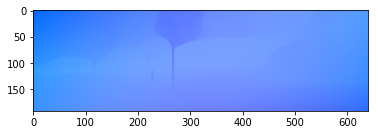

In [20]:
rigid_flow = read_flo_file(os.path.join(cur_dir,'outputs','rigid_flow_fake_0.flo'))
EPE = get_EPE(rigid_flow)
rigid_flow = flow_to_image(rigid_flow)
plt.imshow(rigid_flow)

As you can see, the resulting rigid flow is not 0 everywhere (otherwise a white image would have been printed out).
The resulting `EPE` is the following: 

In [19]:
print('Average EPE: {:6.4}'.format(EPE))

Average EPE: 0.4337


## SEQUENCE 2

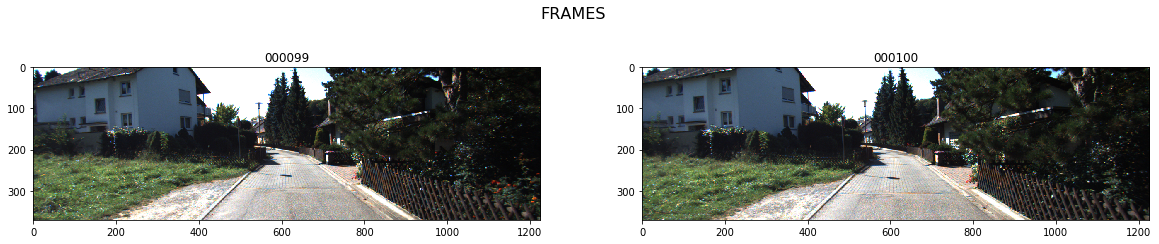

In [21]:
t0_img = cv2.imread(os.path.join(cur_dir,'images','000099.png'))
t1_img = cv2.imread(os.path.join(cur_dir,'images','000100.png'))
t0_img = cv2.cvtColor(t0_img, cv2.COLOR_BGR2RGB)
t1_img = cv2.cvtColor(t1_img, cv2.COLOR_BGR2RGB)

counter = 0
fig = plt.figure(figsize=(20,7))
fig.suptitle("FRAMES", fontsize=16)
for img,title in zip([t0_img, t1_img],['000099','000100']):
    ax = plt.subplot(221+counter)
    ax.title.set_text(title)
    plt.imshow(img)
    counter += 1

plt.show()

### REAL

POSE: 
 T:[ 0.00204395 -0.00469736 -0.00163883] 
 R:[ 0.00012599  0.00074624 -0.03593575]


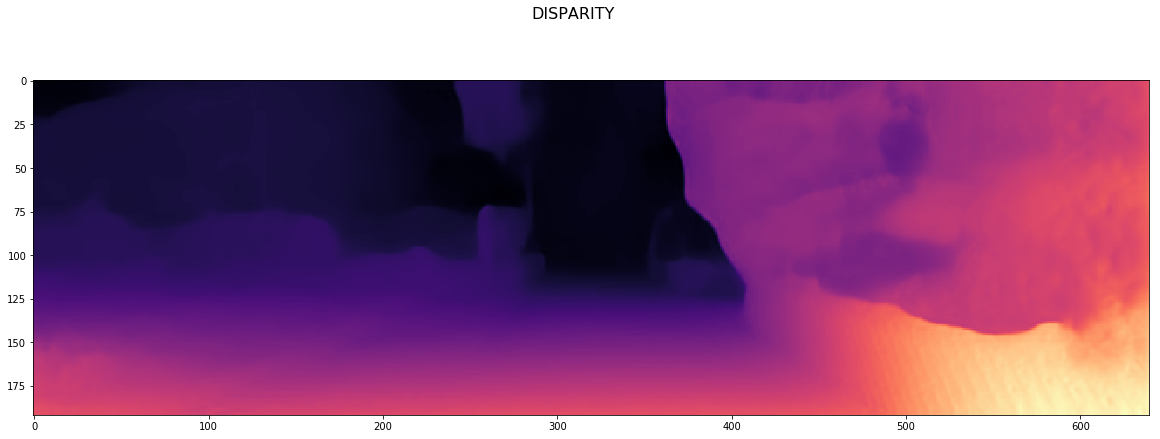

In [25]:
disp = np.load(os.path.join(cur_dir,'monodepth2','disp_99.npy'))
fig = plt.figure(figsize=(20,7))
fig.suptitle("DISPARITY", fontsize=16)
plt.imshow(disp, cmap='magma')

real_pose  = read_pose(os.path.join(cur_dir,'monodepth2','real_poses.txt'))
pose = real_pose[99]
print('POSE: \n T:{} \n R:{}'.format(pose[:3], pose[3:]))

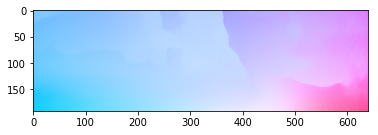

In [23]:
rigid_flow = read_flo_file(os.path.join(cur_dir,'outputs','rigid_flow_real_99.flo'))
rigid_flow = flow_to_image(rigid_flow)
plt.imshow(rigid_flow)

### FAKE

In [24]:
fake_pose  = read_pose(os.path.join(cur_dir,'monodepth2','fake_poses.txt'))
pose = fake_pose[99]
print('POSE: \n T:{} \n R:{}'.format(pose[:3], pose[3:]))

POSE: 
 T:[ 2.4763672e-04  6.9416084e-05 -2.1926242e-04] 
 R:[ 0.00043626 -0.00045107 -0.001118  ]


Average EPE: 0.1991


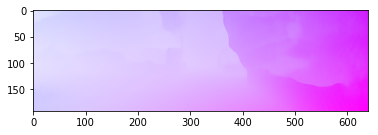

In [27]:
rigid_flow = read_flo_file(os.path.join(cur_dir,'outputs','rigid_flow_fake_99.flo'))
EPE = get_EPE(rigid_flow)
rigid_flow = flow_to_image(rigid_flow)
plt.imshow(rigid_flow)
print('Average EPE: {:6.4}'.format(EPE))

# GEONET

# OPTICAL FLOW TEST
We perform now the analogous test using some dense optical flow methods based on Deep Learning. 

## SelFlow
[SelFlow](https://arxiv.org/pdf/1904.09117.pdf) is an unsupervised optical flow method (Oral CVPR 2019). Differently from others approaches, authors try in a first stage to estimate the optical flow of the scene, then they generates (using super-pixel) occlusions, and use a second optical flow network (with the same structur of the previous one) to infer the optical flow of the augmented scene. Finally, they exploit first stage predictions to guide the second network in occluded regions  